In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from IPython import display

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

from keras.engine.keras_tensor import KerasTensor
from typing import Tuple

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
FILE_PATH_BASE = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = [f'{FILE_PATH_BASE}/monet_tfrec/{f}' for f in os.listdir(f'{FILE_PATH_BASE}/monet_tfrec')]
PHOTO_FILENAMES = [f'{FILE_PATH_BASE}/photo_tfrec/{f}' for f in os.listdir(f'{FILE_PATH_BASE}/photo_tfrec')]

f'Monet tfrec total files: {len(MONET_FILENAMES)}, total tfrec photos: {len(PHOTO_FILENAMES)}'

'Monet tfrec total files: 5, total tfrec photos: 20'

In [3]:
def set_strategy(option: str= None):
    strategy = None
    if option == 'gpu':
        try:
            gpus = tf.config.list_logical_devices('GPU')
            print("Number of available GPUs: ", len(gpus))
            strategy = tf.distribute.MirroredStrategy(gpus)
        except:
            strategy = tf.distribute.get_strategy()
    if option == 'tpu':
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Device:', tpu.master())
            tf.config.experimental_connect_to_cluster(tpu)
            tpus = tf.tpu.experimental.initialize_tpu_system(tpu)
            print(tpus)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
        except:
            strategy = tf.distribute.get_strategy()
    if option == None:
        strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)
    return strategy

# EDA

In [4]:
RAW_MONET_DATASET = tf.data.TFRecordDataset(MONET_FILENAMES)
RAW_PHOTOS_DATASET = tf.data.TFRecordDataset(PHOTO_FILENAMES)

FILE_PROPS = {
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string)
}

MONET_DATASET = RAW_MONET_DATASET.map(lambda x: tf.io.parse_single_example(x, FILE_PROPS))
PHOTOS_DATASET = RAW_PHOTOS_DATASET.map(lambda x: tf.io.parse_single_example(x, FILE_PROPS))

monet_example = next(iter(MONET_DATASET))
photo_example = next(iter(PHOTOS_DATASET))

1

b'monet'

b'b256e61a5d'

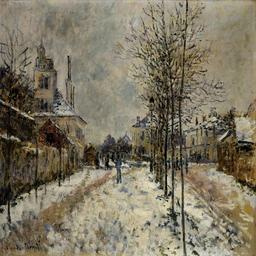

1

b'photo'

b'ef833e60b4'

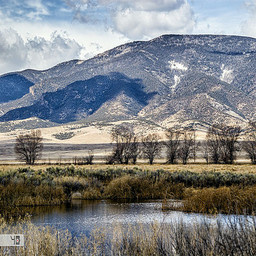

2

b'monet'

b'49337b68f4'

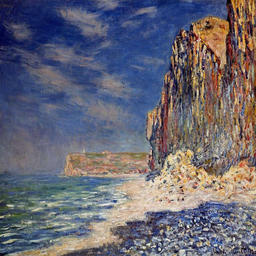

2

b'photo'

b'2a14b928c4'

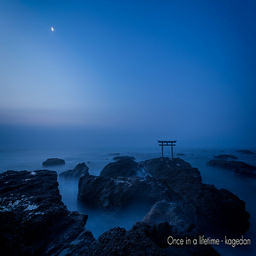

In [5]:
n = 2
for idx, (m, p) in enumerate(zip(MONET_DATASET.take(n), PHOTOS_DATASET.take(n))):
    display.display(idx+1, m['target'].numpy(), m['image_name'].numpy(), display.Image(data=m['image'].numpy()))
    display.display(idx+1, p['target'].numpy(), p['image_name'].numpy(), display.Image(data=p['image'].numpy()))

In [6]:
class Down_Sampler:
    def __init__(self, x: keras.layers.Input, filters: int, kernel_size: int, strides: int = 2, with_instance_normalization: bool = True, mean: float=0.0, stddev: float=0.2)->None:
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.is_normalized = with_instance_normalization
        self.mean = mean
        self.stddev = stddev
        self.x = self.build_components(x)
        
    def build_components(self,  x: keras.layers.Input)->KerasTensor:
        x = layers.Conv2D(
            self.filters, 
            self.kernel_size, 
            strides=self.strides, 
            padding='same', 
            kernel_initializer=tf.random_normal_initializer(self.mean, self.stddev),
            use_bias=False
        )(x)
        if self.is_normalized:
            x = tfa.layers.InstanceNormalization(
                gamma_initializer=keras.initializers.RandomNormal(mean=self.mean, stddev=self.stddev)
            )(x)
        x = layers.LeakyReLU()(x)
        return x
    

class Up_Sampler:
    def __init__(self, x: keras.layers.Input, filters: int, kernel_size: int, strides: int = 2, with_dropout: bool = False, mean: float=0.0, stddev: float=0.2)->None:
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.has_dropout = with_dropout
        self.mean = mean
        self.stddev = stddev
        self.x = self.build_components(x)
        
    def build_components(self,  x: keras.layers.Input)->KerasTensor:
        x = layers.Conv2DTranspose(
            self.filters, 
            self.kernel_size, 
            strides=self.strides, 
            padding='same', 
            kernel_initializer=tf.random_normal_initializer(self.mean, self.stddev),
            use_bias=False
        )(x)
        x = tfa.layers.InstanceNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=self.mean, stddev=self.stddev)
        )(x)
        if self.has_dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.ReLU()(x)
        return x

class UNET_Generator:
    def __init__(self, name: str, input_shape: Tuple[int, int, int], output_channels: int = 3, kernel_size: int = 4, strides: int = 2):
        self.name = name
        self.inputs = layers.Input(shape=input_shape)
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.model = self.build_model()
        
    def build_model(self)->keras.Model:
        x = self.inputs
        kernel_size = self.kernel_size
        strides = self.strides
        d1 = Down_Sampler(x, 64, kernel_size=kernel_size, strides=self.strides, with_instance_normalization=False).x
        d2 = Down_Sampler(d1, 128, kernel_size=kernel_size, strides=strides).x
        d3 = Down_Sampler(d2, 256, kernel_size=kernel_size, strides=strides).x
        d4 = Down_Sampler(d3, 512, kernel_size=kernel_size, strides=strides).x
        d5 = Down_Sampler(d4, 512, kernel_size=kernel_size, strides=strides).x
        d6 = Down_Sampler(d5, 512, kernel_size=kernel_size, strides=strides).x
        d7 = Down_Sampler(d6, 512, kernel_size=kernel_size, strides=strides).x
        d8 = Down_Sampler(d7, 512, kernel_size=kernel_size, strides=strides).x
        u1 = Up_Sampler(d8, 512, kernel_size=kernel_size, strides=strides, with_dropout=True).x
        s1 = layers.Concatenate()([u1,d7])
        u2 = Up_Sampler(s1, 512, kernel_size=kernel_size, strides=strides, with_dropout=True).x
        s2 = layers.Concatenate()([u2,d6])
        u3 = Up_Sampler(s2, 512, kernel_size=kernel_size, strides=strides, with_dropout=True).x
        s3 = layers.Concatenate()([u3,d5])
        u4 = Up_Sampler(s3, 512, kernel_size=kernel_size, strides=strides).x
        s4 = layers.Concatenate()([u4,d4])
        u5 = Up_Sampler(s4, 256, kernel_size=kernel_size, strides=strides).x
        s5 = layers.Concatenate()([u5,d3])
        u6 = Up_Sampler(s5, 128, kernel_size=kernel_size, strides=strides).x
        s6 = layers.Concatenate()([u6,d2])
        u7 = Up_Sampler(s6, 64, kernel_size=kernel_size, strides=strides).x
        s7 = layers.Concatenate()([u7,d1])
        final_layer = layers.Conv2DTranspose(
            self.output_channels, 
            kernel_size,
            strides=strides,
            padding='same',
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation='tanh'
        )(s7)
        return keras.Model(inputs=self.inputs, outputs=final_layer, name=self.name)
        
class Discriminator:
    def __init__(self, name: str, input_shape: Tuple[int, int, int], output_channels: int = 3, kernel_size: int = 4, strides: int = 2)->None:
        self.name = name
        self.inputs = layers.Input(shape=input_shape)
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.model = self.build_model()
    
    def build_model(self)->keras.Model:
        x = self.inputs
        kernel_size = self.kernel_size
        strides = self.strides
        d1 = Down_Sampler(x, 64, kernel_size=kernel_size, strides=self.strides, with_instance_normalization=False).x
        d2 = Down_Sampler(x, 128, kernel_size=kernel_size, strides=self.strides).x
        d3 = Down_Sampler(x, 256, kernel_size=kernel_size, strides=self.strides).x
        zp1 = layers.ZeroPadding2D()(d3)
        c1 = layers.Conv2D(
            512, 4, 
            strides=1,
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False
        )(zp1)
        n1 = tfa.layers.InstanceNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        )(c1)
        lr = layers.LeakyReLU()(n1)
        zp2 = layers.ZeroPadding2D()(lr)
        final_layer = layers.Conv2D(1,4, strides=1,kernel_initializer=tf.random_normal_initializer(0.0, 0.02))(zp2)
        return keras.Model(inputs=self.inputs, outputs=final_layer, name=self.name)

In [7]:
with set_strategy().scope():
    monet_gen = UNET_Generator(name='Monet Generator',input_shape=(256,256,3)).model
    photo_gen = UNET_Generator(name='Photo Generator',input_shape=(256,256,3)).model
    monet_dscr = Discriminator(name='Monet Discriminator', input_shape=(256, 256,3)).model
    photo_dscr = Discriminator(name='Photo Discriminator', input_shape=(256, 256,3)).model

Number of replicas: 1
